In [1]:
import os, sys
os.environ["OMP_NUM_THREADS"] = "1" 
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1" 
os.environ["VECLIB_MAXIMUM_THREADS"] = "1" 
os.environ["NUMEXPR_NUM_THREADS"] = "1" 

In [2]:
%load_ext autoreload
%autoreload 2

In [4]:
import pandas as pd
import os
import numpy as np
import random
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

sys.path.append('./src/')
from read_data_utils import *
from simulations_utils import *
import pickle

from scipy.spatial.distance import hamming


In [6]:
sys.path.append('./hmmcopy_comparison')

# import massey
import hmmcopy_NBcomparison

## Set parameters for simulations

coordinates must be one of 'arms' (segments coorespond to chromosome arms), 'real_segments' (breakpoint coordinates are taken from a real funnel dataset) and 'random' (breakpoints are assigned ranomly, mimicking the length observed in Funnel)

In [7]:
coordinates = 'random'

In [8]:
nclones = 50
nchanges = 50
ncells = 50
reads_per_copy = 100
nb_dispersion = 0.05
outliers_perc = 0

In [9]:
output_directory = "simulations"
os.makedirs(output_directory, exist_ok=True)
output_current = f"{output_directory}/{nb_dispersion}disp_{nclones}clones_{nchanges}changes_{reads_per_copy}reads/"#_{outliers_perc*100}%outliers/"
os.makedirs(output_current, exist_ok=True)

In [10]:
funnel_path = '/nemo/project/proj-tracerx-lung/tctProjects/zaccariaLab/ccg_lab/datasets/Funnell2022'
wd = '/camp/home/patrunl/home/working/patrunl/single_cell_dlp/'
os.chdir(f'{wd}/funnel_data/')

In [11]:
import pickle
from parallelize_cells import *


## Now load results and compute best ploidy

In [12]:
test = pickle.load(open(f'{output_current}/nbhmm_output.pkl', 'rb'))

In [13]:
tmp = test[0].copy()

dict_hmm_segmentation = test[4]

tmp.sort_values(['cell_id', 'start_absolute'], inplace=True)

# tmp.fillna(method='ffill', inplace=True)
tmp['minor_allele'] = tmp['alt_reads'].copy()
tmp['totalcounts'] = tmp['SNP_reads'].astype(int)
# tmp['BAF'] = tmp['minor_allele'] / tmp['totalcounts']

In [14]:
from tqdm import tqdm
from ploidy_utils import *
from compute_cnv_hmm import normalise_log_probability

In [16]:
final_results = pickle.load(open(f'{output_current}/nbhmm_ploidy_results.pkl', 'rb'))

In [17]:
nb_hamming = final_results.groupby('cell_id').apply(lambda x : hamming(x['tot_CN'].values, x['map_totcn_segment'].values)) 

<Axes: >

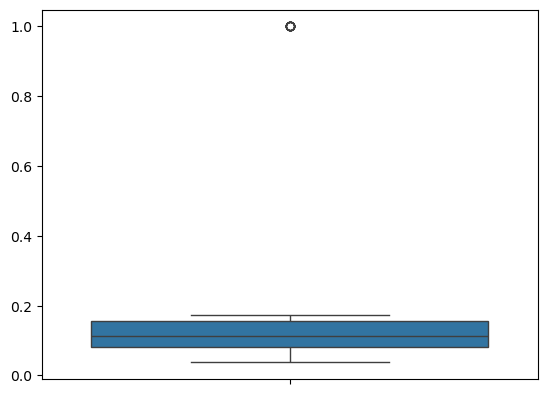

In [18]:

nb_ploidy = final_results.groupby('cell_id')['map_totcn_segment'].mean()
gt_ploidy = final_results.groupby('cell_id')['tot_CN'].mean()
sns.boxplot(nb_hamming)

## Now load HMMCOPY results

In [19]:
data = pd.read_csv(f'{output_current}/hmmcopy_input.csv')
data['modal_curve'] = 1

In [20]:
import shlex, shutil

In [21]:
vanres = pickle.load(open(f'{output_current}/hmmcopy_results.pkl', 'rb'))

In [22]:
hmmcopy_hamming = vanres.groupby('cell_id').apply(lambda x : hamming(x['tot_CN'].values, x['state'].values))
hmm_copy_ploidy = vanres.groupby('cell_id')['state'].mean()

<Axes: >

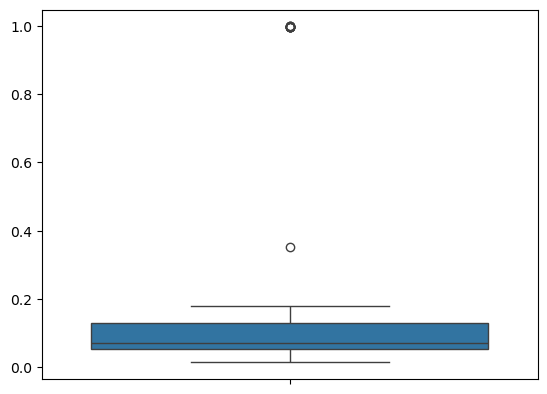

In [23]:
sns.boxplot(hmmcopy_hamming)

In [24]:
hamming_df = hmmcopy_hamming.reset_index()
hamming_df.columns = ['cell_id', 'hamming_hmmcopy']
# hamming_df['method'] = 'hmmcopy'

hamming_df['hamming_nb'] = hamming_df['cell_id'].map(nb_hamming)
# hamming_df['deltahamming'] = hamming_df['hamming_nb'] - hamming_df['hamming_hmmcopy']


In [25]:
# pd.wide_to_long(hamming_df, stubnames='hamming', i=['cell_id'], j = 'method', sep = '_')
long_df = pd.melt(hamming_df, id_vars=['cell_id'], value_vars=['hamming_hmmcopy', 'hamming_nb'], var_name='method', value_name='hamming')

In [26]:
hamming_df['ploidy_hmmcopy'] = hamming_df['cell_id'].map(hmm_copy_ploidy)
hamming_df['ploidy_nb'] = hamming_df['cell_id'].map(nb_ploidy)
# hamming_df['deltaploidy'] = hamming_df['ploidy_nb'] - hamming_df['ploidy_hmmcopy']
hamming_df['ploidy_gt'] = hamming_df['cell_id'].map(gt_ploidy)
hamming_df['deltaploidy_hmmcopy'] = np.abs(hamming_df['ploidy_hmmcopy'] - hamming_df['ploidy_gt'])
hamming_df['deltaploidy_nb'] = np.abs(hamming_df['ploidy_nb'] - hamming_df['ploidy_gt'])

In [27]:
# pd.wide_to_long(hamming_df, stubnames='hamming', i=['cell_id'], j = 'method', sep = '_')
long_df = pd.melt(hamming_df, id_vars=['cell_id'], value_vars=['deltaploidy_nb', 'deltaploidy_hmmcopy'], var_name='method', value_name='deltaploidy')
long_df

,cell_id,method,deltaploidy
0,cell_1,deltaploidy_nb,0.063933
1,cell_10,deltaploidy_nb,0.030702
2,cell_11,deltaploidy_nb,0.061585
3,cell_12,deltaploidy_nb,3.561616
4,cell_13,deltaploidy_nb,0.062386
...,...,...,...
95,cell_50,deltaploidy_hmmcopy,0.010675
96,cell_6,deltaploidy_hmmcopy,0.007807
97,cell_7,deltaploidy_hmmcopy,NaN
98,cell_8,deltaploidy_hmmcopy,0.001518


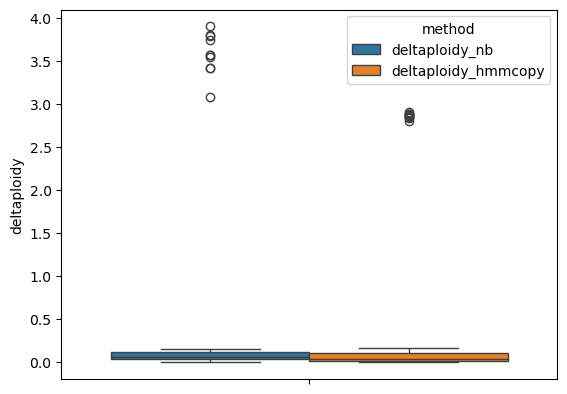

In [28]:
sns.boxplot(data = long_df, y = 'deltaploidy', hue = 'method')
# plt.ylim(0,0.5)
plt.show()
# sns.boxplot(data = hamming_df, y = 'deltaploidy_nb')
# plt.ylim(0,0.5)

In [29]:
hamming_df[hamming_df['deltaploidy_hmmcopy'] > 1]

,cell_id,hamming_hmmcopy,hamming_nb,ploidy_hmmcopy,ploidy_nb,ploidy_gt,deltaploidy_hmmcopy,deltaploidy_nb
6,cell_15,0.998339,0.081117,5.810434,2.917553,2.965093,2.845341,0.047540
13,cell_21,0.998505,0.066069,5.770508,2.845120,2.885790,2.884718,0.040671
24,cell_31,0.998672,0.102475,5.834274,2.926424,2.960140,2.874135,0.033715
31,cell_38,0.998665,0.068902,5.785845,2.843343,2.883550,2.902295,0.040207
32,cell_39,0.998164,0.074958,5.816194,2.940902,2.960768,2.855426,0.019866
33,cell_4,0.999332,0.122388,5.930983,3.025414,3.091958,2.839025,0.066544
34,cell_40,0.999498,0.084462,5.802843,2.921224,2.961030,2.841813,0.039806
37,cell_43,0.998333,0.086253,5.922333,3.063730,3.117451,2.804883,0.053720
41,cell_47,0.998838,0.094124,5.968631,3.009296,3.089143,2.879487,0.079847
42,cell_48,0.999335,0.076347,5.763337,2.862774,2.885396,2.877941,0.022621


<Axes: xlabel='ploidy_gt', ylabel='Count'>

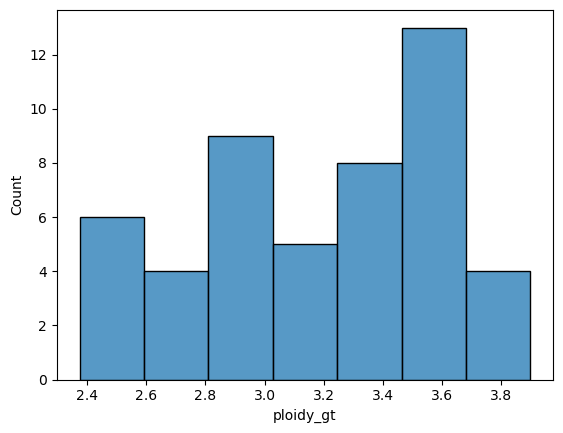

In [30]:
sns.histplot(hamming_df['ploidy_gt'])

<Axes: xlabel='ploidy_gt', ylabel='ploidy_hmmcopy'>

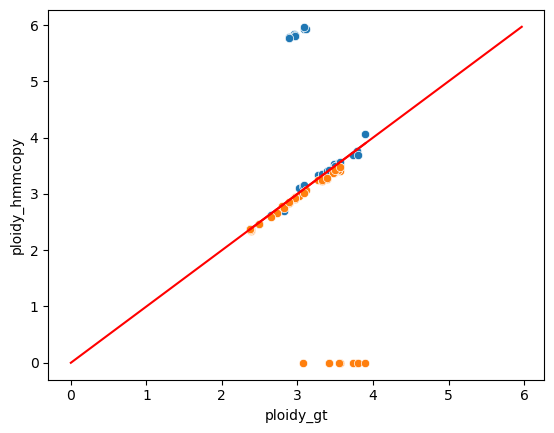

In [31]:
sns.scatterplot(data = hamming_df, x = 'ploidy_gt', y = 'ploidy_hmmcopy')
lim = [min(hamming_df['ploidy_gt'].min(), hamming_df['ploidy_hmmcopy'].min()), max(hamming_df['ploidy_gt'].max(), hamming_df['ploidy_hmmcopy'].max())]
plt.plot(lim, lim, '-r')
# lims = [max(x0, y0), min(x1, y1)]
# g.ax_joint.plot(lims, lims, '-r')
# show()
lim = [min(hamming_df['ploidy_gt'].min(), hamming_df['ploidy_nb'].min()), max(hamming_df['ploidy_gt'].max(), hamming_df['ploidy_nb'].max())]
plt.plot(lim, lim, '-r')

sns.scatterplot(data = hamming_df, x = 'ploidy_gt', y = 'ploidy_nb')


<Axes: xlabel='ploidy_gt', ylabel='ploidy_nb'>

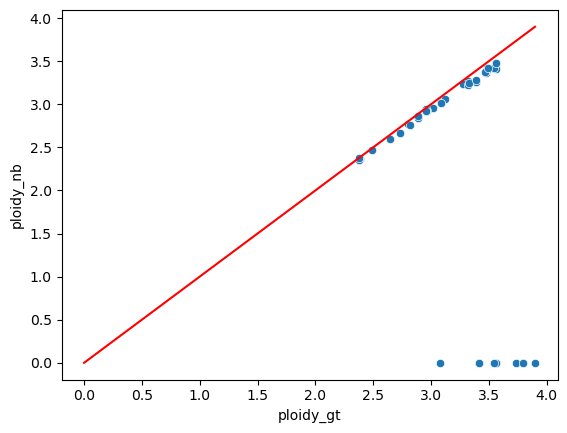

In [32]:
lim = [min(hamming_df['ploidy_gt'].min(), hamming_df['ploidy_nb'].min()), max(hamming_df['ploidy_gt'].max(), hamming_df['ploidy_nb'].max())]
plt.plot(lim, lim, '-r')

sns.scatterplot(data = hamming_df, x = 'ploidy_gt', y = 'ploidy_nb')

## Checkout the cells for which hmmcopy infers the wrong ploidy

In [33]:
hamming_df[hamming_df['deltaploidy_hmmcopy'] > 1]

,cell_id,hamming_hmmcopy,hamming_nb,ploidy_hmmcopy,ploidy_nb,ploidy_gt,deltaploidy_hmmcopy,deltaploidy_nb
6,cell_15,0.998339,0.081117,5.810434,2.917553,2.965093,2.845341,0.047540
13,cell_21,0.998505,0.066069,5.770508,2.845120,2.885790,2.884718,0.040671
24,cell_31,0.998672,0.102475,5.834274,2.926424,2.960140,2.874135,0.033715
31,cell_38,0.998665,0.068902,5.785845,2.843343,2.883550,2.902295,0.040207
32,cell_39,0.998164,0.074958,5.816194,2.940902,2.960768,2.855426,0.019866
33,cell_4,0.999332,0.122388,5.930983,3.025414,3.091958,2.839025,0.066544
34,cell_40,0.999498,0.084462,5.802843,2.921224,2.961030,2.841813,0.039806
37,cell_43,0.998333,0.086253,5.922333,3.063730,3.117451,2.804883,0.053720
41,cell_47,0.998838,0.094124,5.968631,3.009296,3.089143,2.879487,0.079847
42,cell_48,0.999335,0.076347,5.763337,2.862774,2.885396,2.877941,0.022621


In [34]:
from ploidy_utils import *
current = tmp[tmp['cell_id'] == 'cell_43'].copy()
# current = current[current['hmm_states']!=0].copy()
# test = [compute_ploidy_solution(current, dict_hmm_segmentation['cell_17'], n, plot=True) for n in range(1, 10)]


In [36]:
# plt.plot([x[0] for x in test])
# plt.show()
# plt.plot([x[0] for x in test[1:]])
# # [x[0] for x in test]

In [40]:
cell = 'cell_43'
current = tmp[tmp['cell_id'] == 'cell_43'].copy()
current = current[current['hmm_states']!=0].copy()
current['segment_id'] = compute_segment_id(current['hmm_states'])
test = min((compute_ploidy_solution(current, dict_hmm_segmentation[cell], n) for n in range(1, 4)), key=(lambda v : v[0]))
tot_cnvs = np.arange(0, test[1].n_components)

tot_copies = np.repeat(tot_cnvs, (np.floor(tot_cnvs / 2)).astype(int) + 1)
b_copies = np.zeros(int(np.sum(np.floor(tot_cnvs / 2) + 1 )))
j = 0
for c in tot_cnvs:
	b_range = np.arange(0, np.floor(c/2) + 1)
	for i in range(0, len(b_range)):
		b_copies[j] = int(b_range[i])
		j = j + 1
b_copies = b_copies.astype(int)
a_copies = tot_copies - b_copies

test[2]['map_totcn_segment'] = tot_copies[test[2]['map_cn_segment'].values]
test[2]['map_Acn_segment'] = a_copies[test[2]['map_cn_segment'].values]
test[2]['map_Bcn_segment'] = b_copies[test[2]['map_cn_segment'].values]

In [43]:
cmap = plt.cm.tab20
color_dict = {i: cmap(i) for i in range(1, 21)}

<Axes: xlabel='start_absolute', ylabel='cor_gc_shifted'>

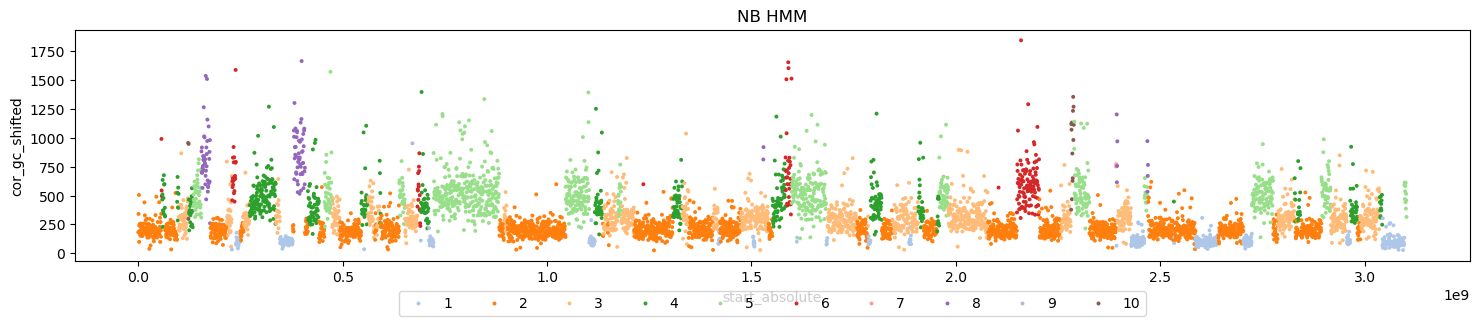

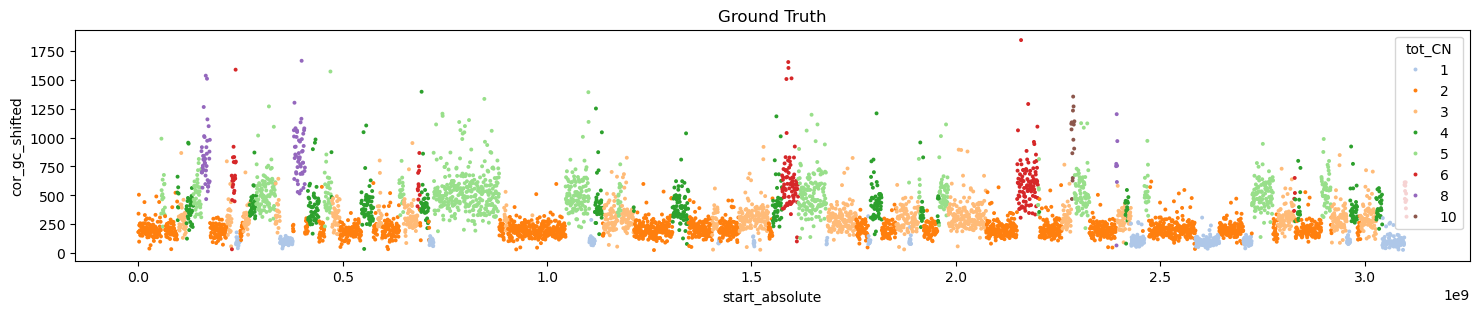

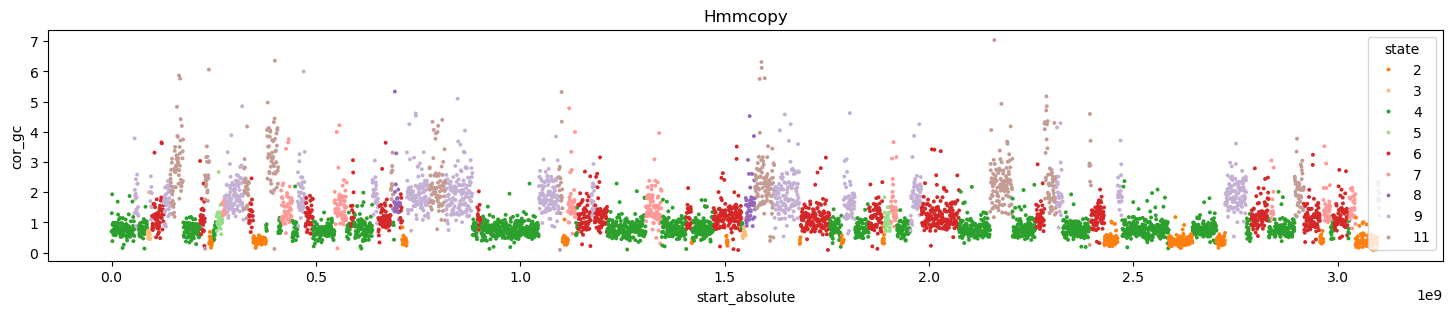

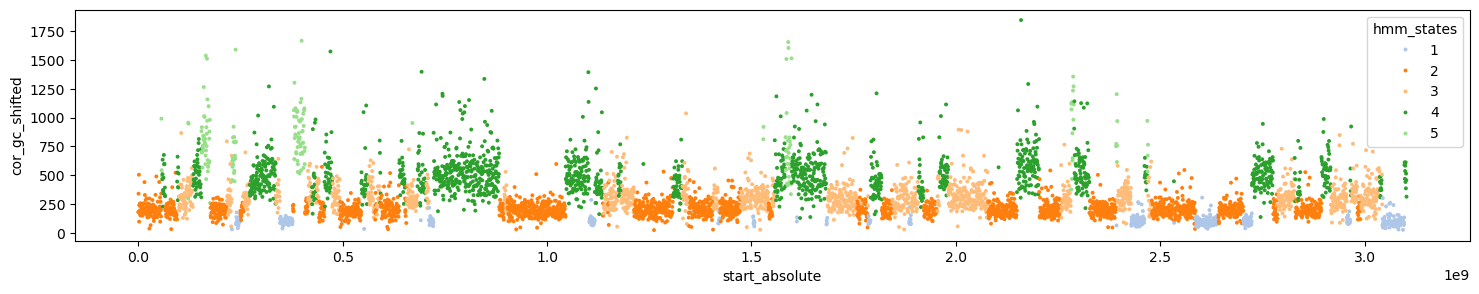

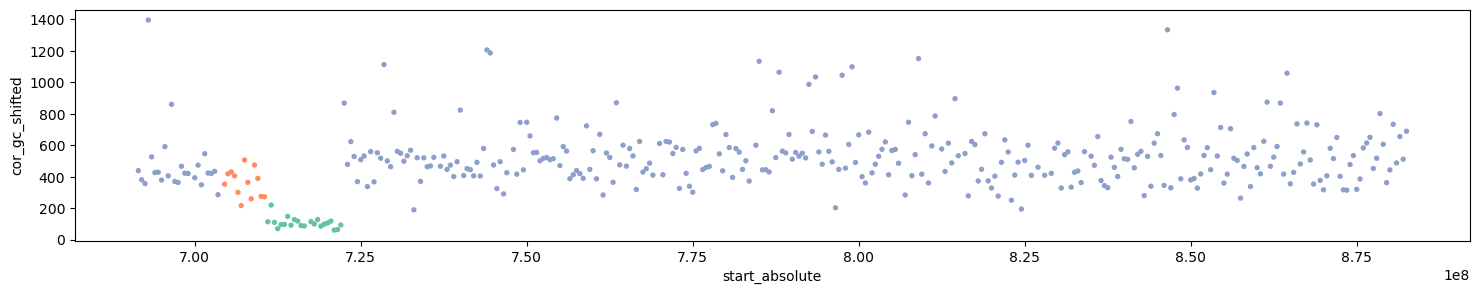

In [46]:
data_plot = test[2]#final_results[final_results['cell_id'] == 'cell_43'].copy()
# data_plot = data_plot[data_plot['hmm_states'] != 0]
plt.figure(figsize = (18,3))
sns.scatterplot(x = 'start_absolute', y = 'cor_gc_shifted', data = data_plot,
			s = 8, linewidth = 0, hue = 'map_totcn_segment', palette = color_dict)
# for m in test[1].means_:
# 	plt.axhline(m, color = 'black', linestyle = '--', alpha = 0.5)
plt.legend(bbox_to_anchor=(0.5, -0.1), loc='upper center', ncol=len(plt.gca().legend_.get_texts()))
plt.title('NB HMM')

plt.figure(figsize = (18,3))
sns.scatterplot(x = 'start_absolute', y = 'cor_gc_shifted', data = data_plot,
			s = 8, linewidth = 0, hue = 'tot_CN', palette = color_dict)
plt.title('Ground Truth')
plt.figure(figsize = (18,3))
sns.scatterplot(x = 'start_absolute', y = 'cor_gc', data = vanres[vanres['cell_id'] == cell],
			s = 8, linewidth = 0, hue = 'state', palette = color_dict)
plt.title('Hmmcopy')

plt.figure(figsize = (18,3))
sns.scatterplot(x = 'start_absolute', y = 'cor_gc_shifted', data = data_plot,
			s = 8, linewidth = 0, hue = 'hmm_states', palette = color_dict)
plt.figure(figsize = (18,3))
sns.scatterplot(x = 'start_absolute', y = 'cor_gc_shifted', data = data_plot[data_plot['chr'] == 4],
			s = 15, linewidth = 0, hue = 'hmm_states', palette = 'Set2', legend = False)


# plt.figure(figsize = (18,3))
# sns.scatterplot(x = 'start_absolute', y = 'cor_gc_shifted', data = data_plot,
# 			s = 8, linewidth = 0, hue = 'map_Acn_segment', palette = 'tab20')
# plt.figure(figsize = (18,3))
# sns.scatterplot(x = 'start_absolute', y = 'cor_gc_shifted', data = data_plot,
# 			s = 8, linewidth = 0, hue = 'map_Bcn_segment', palette = 'tab20')
# plt.figure(figsize = (18,3))
# sns.scatterplot(x = 'start_absolute', y = 'BAF', data = data_plot,
# 			s = 8, linewidth = 0, hue = 'map_Bcn_segment', palette = 'tab20')

In [97]:
data_plot[data_plot['chr'] == 4]['hmm_states']

264445    4
264446    4
264447    4
264448    4
264449    4
         ..
264823    4
264824    4
264825    4
264826    4
264827    4
Name: hmm_states, Length: 369, dtype: int64

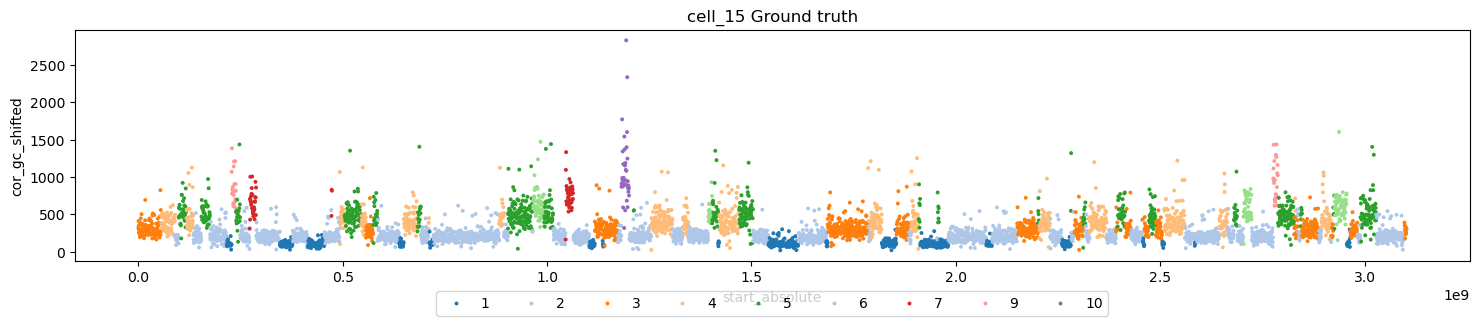

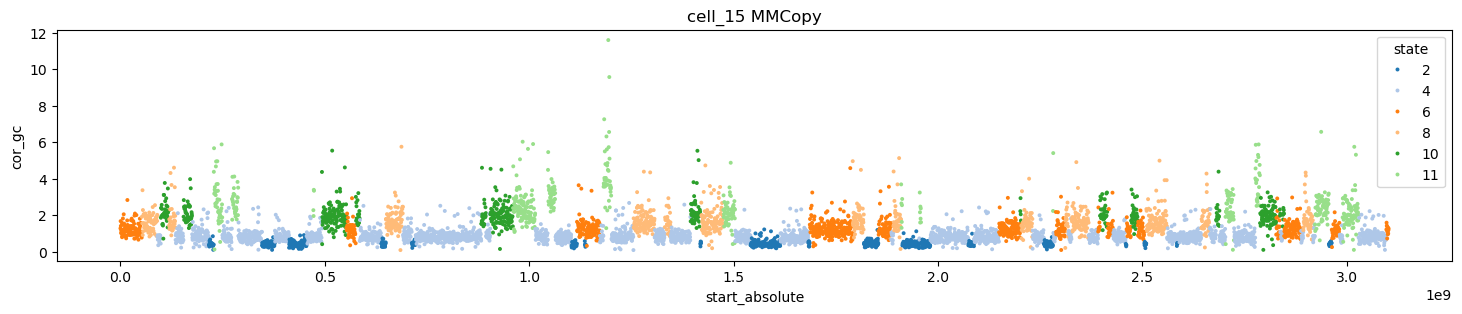

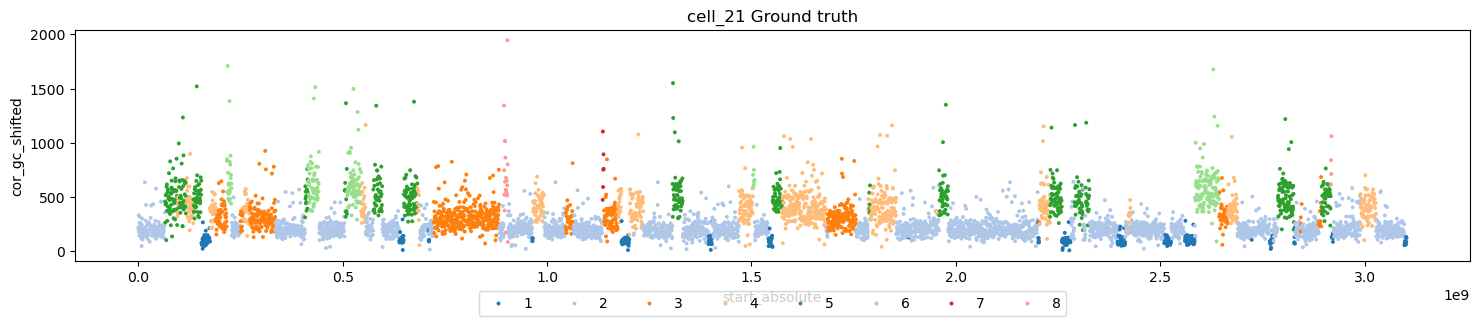

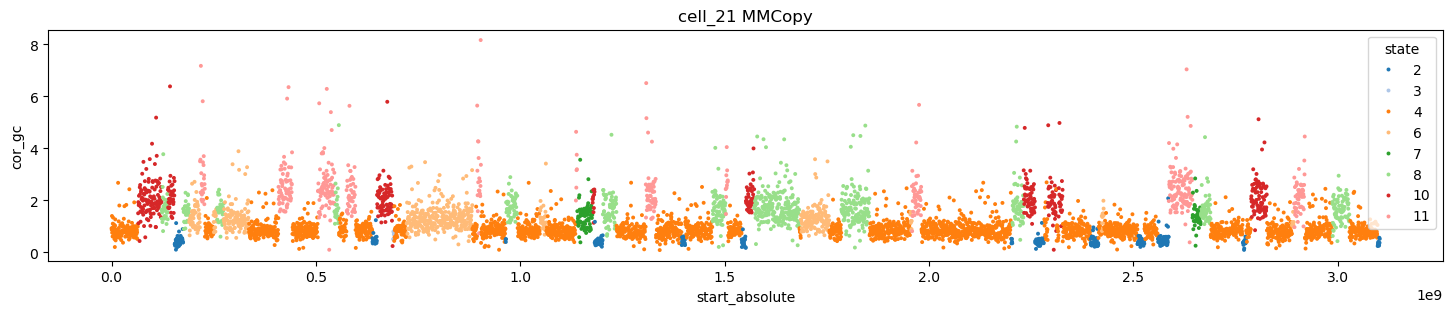

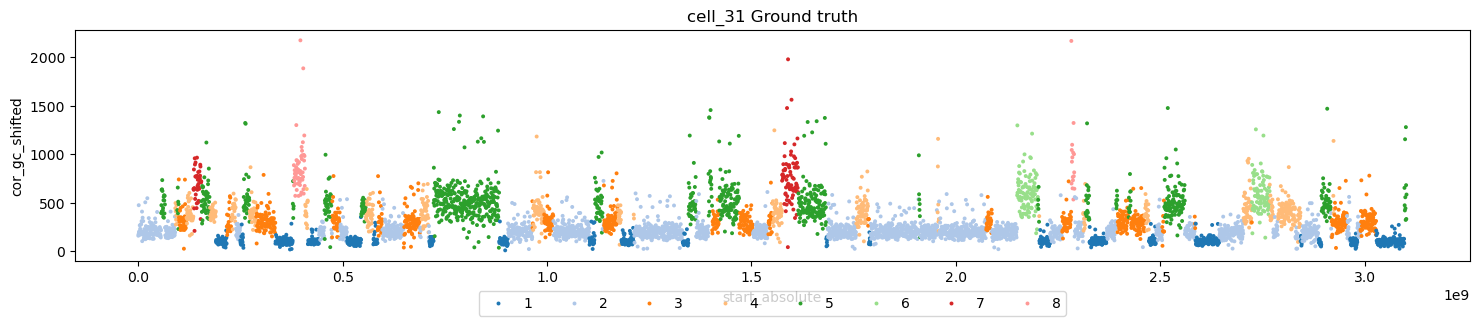

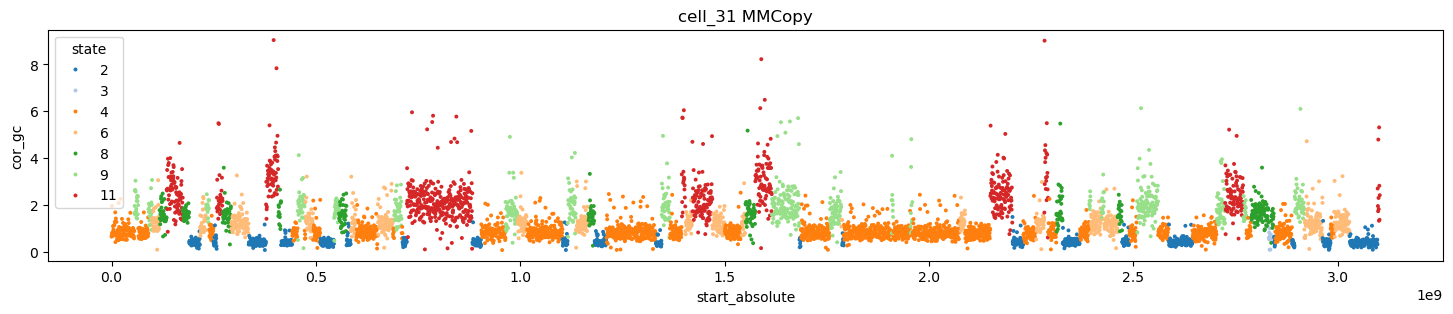

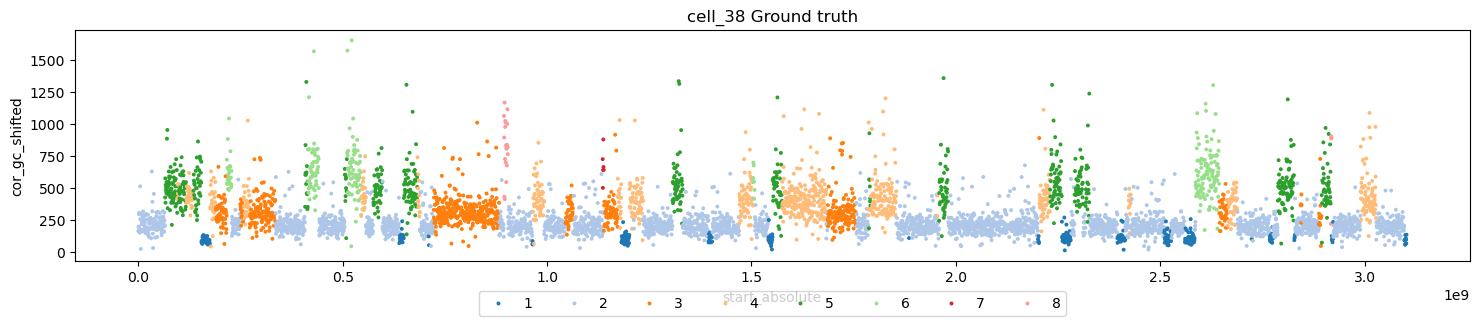

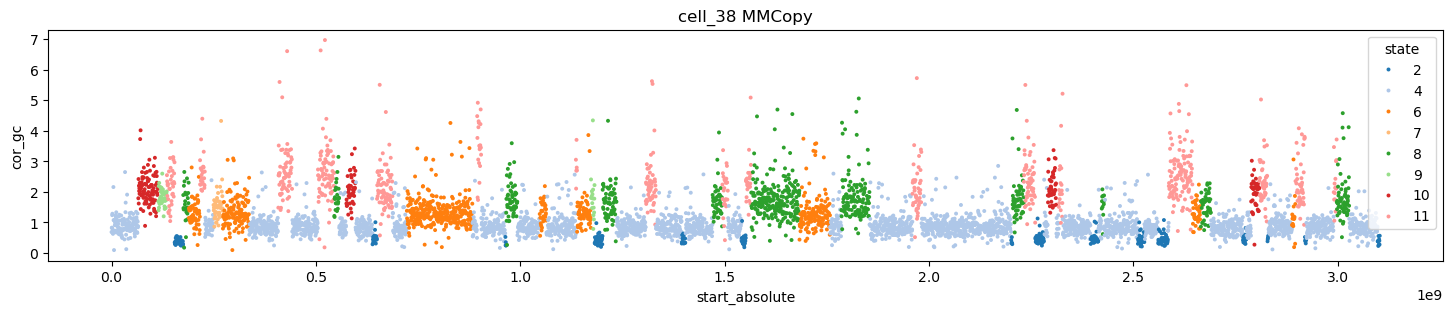

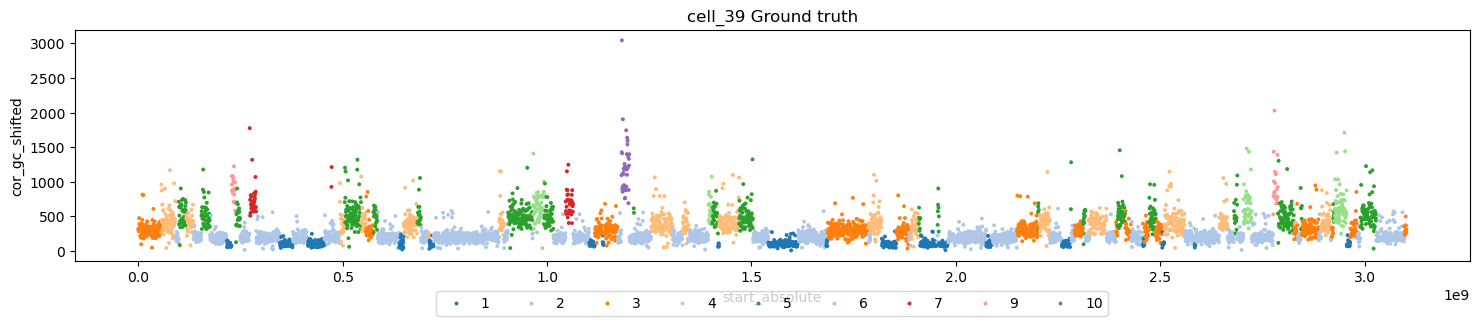

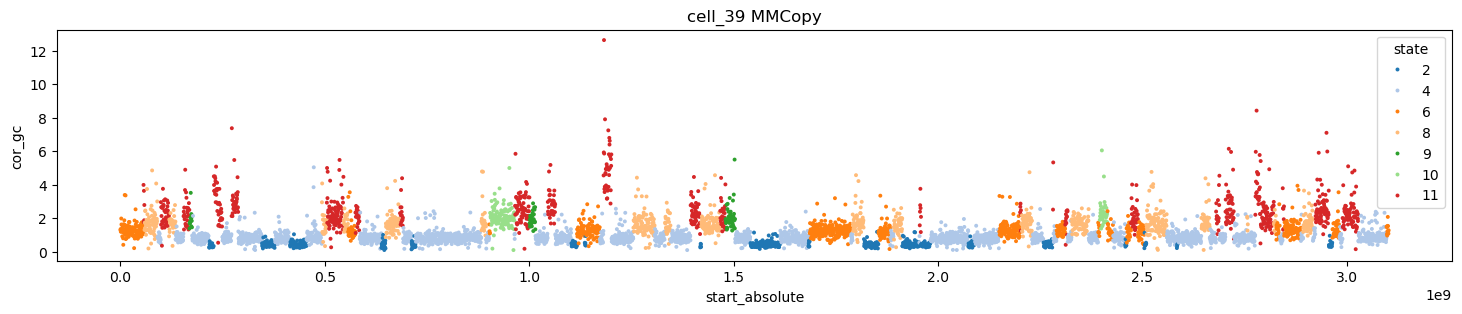

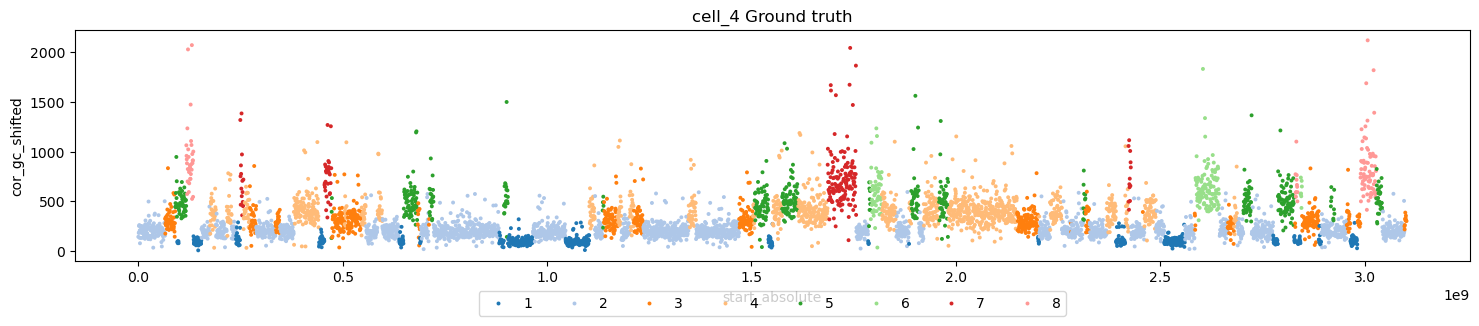

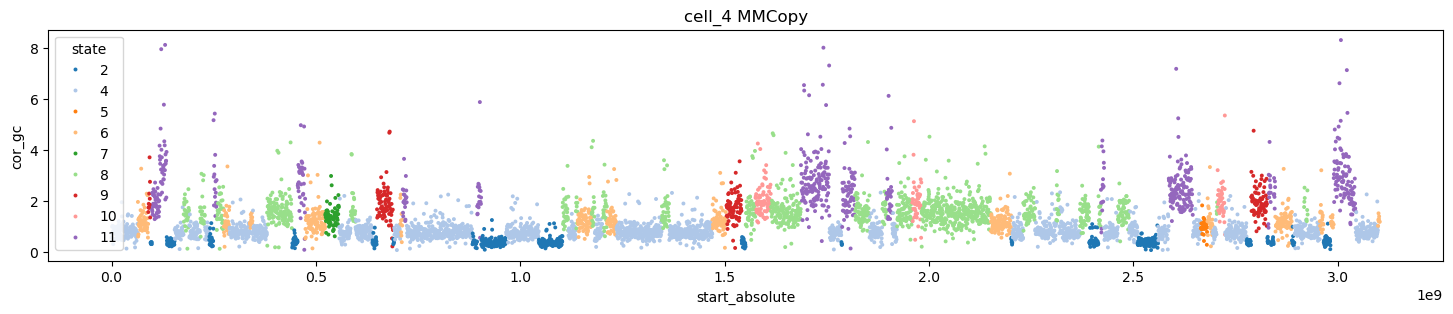

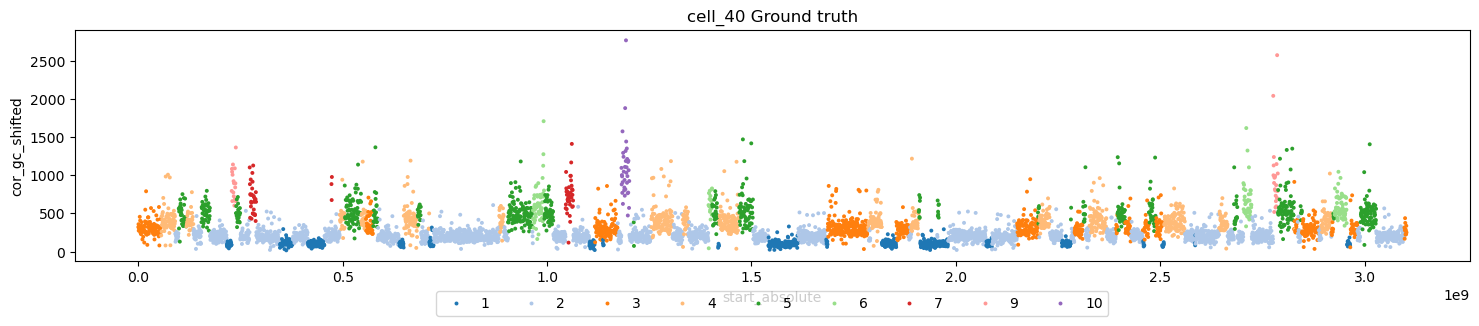

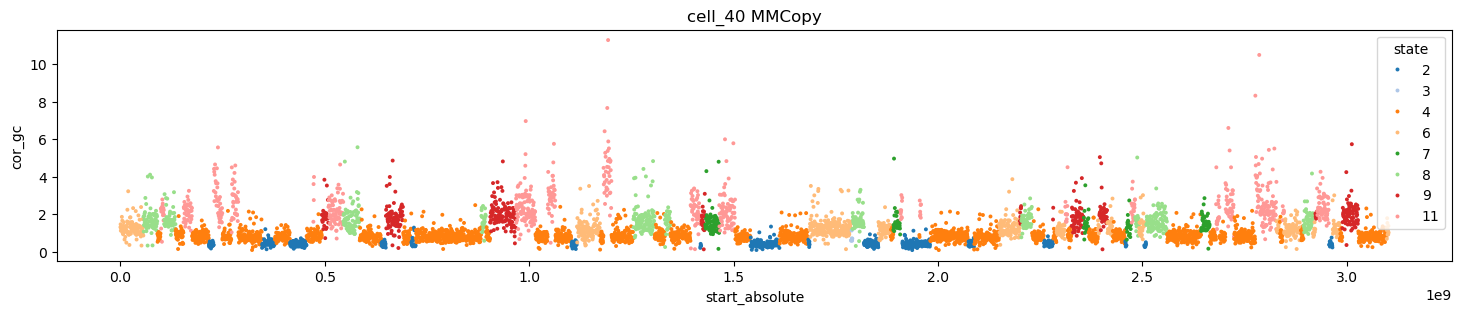

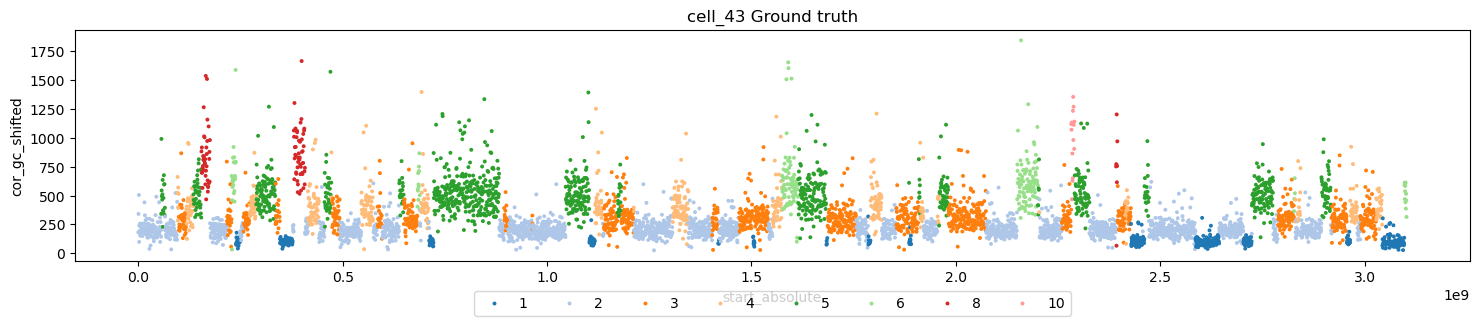

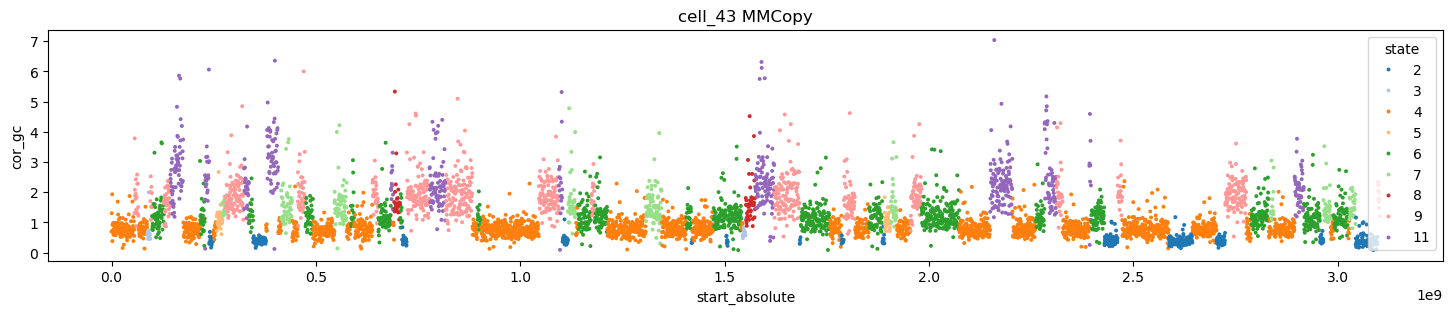

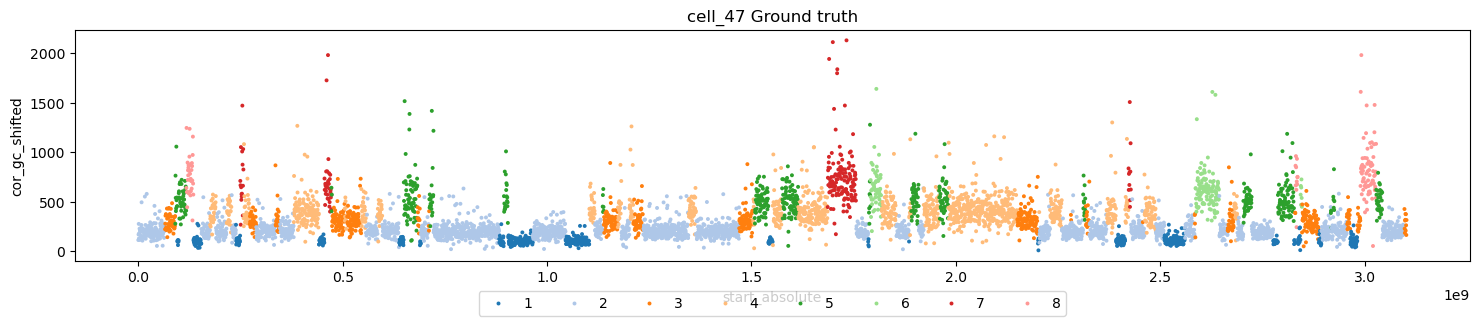

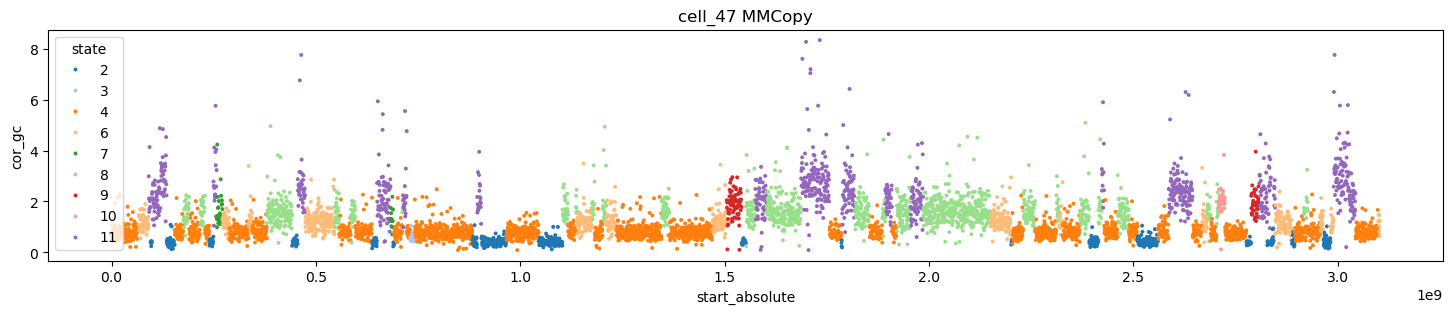

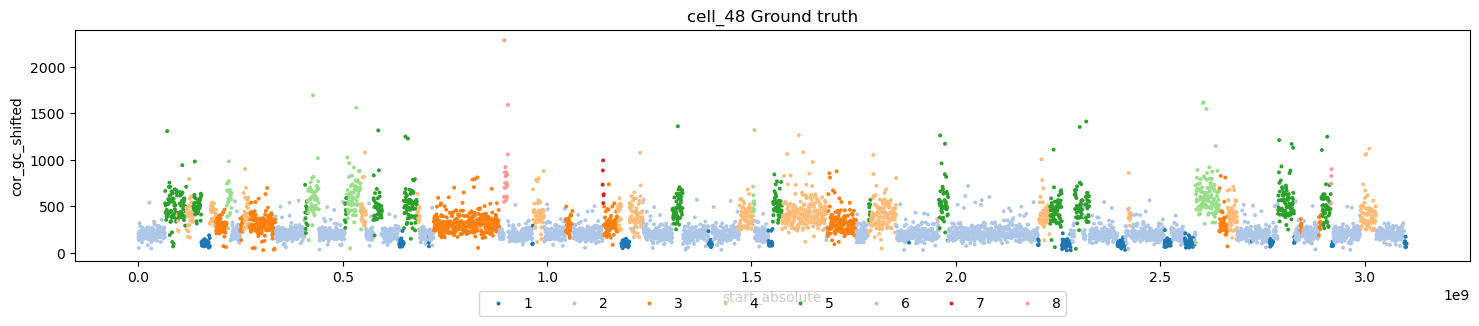

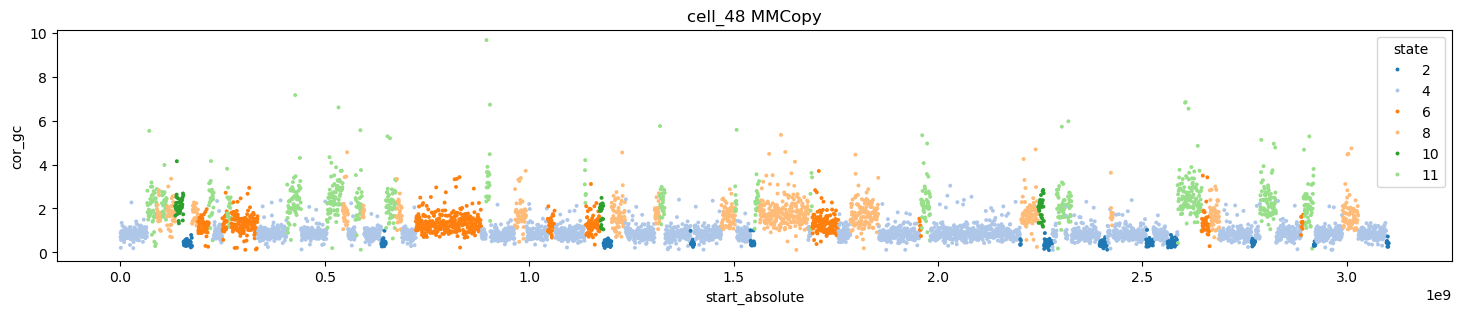

In [65]:
for c in hamming_df[hamming_df['deltaploidy_hmmcopy'] > 1]['cell_id'].values:

	data_plot = final_results[final_results['cell_id'] == c].copy()
	data_plot = data_plot[data_plot['hmm_states'] != 0]
	plt.figure(figsize = (18,3))
	sns.scatterplot(x = 'start_absolute', y = 'cor_gc_shifted', data = data_plot,
				s = 8, linewidth = 0, hue = 'tot_CN', palette = 'tab20')
	plt.title(f'{c} Ground truth')
	# for m in test[1].means_:
	# 	plt.axhline(m, color = 'black', linestyle = '--', alpha = 0.5)
	plt.legend(bbox_to_anchor=(0.5, -0.1), loc='upper center', ncol=len(plt.gca().legend_.get_texts()))

	plt.figure(figsize = (18,3))
	sns.scatterplot(x = 'start_absolute', y = 'cor_gc', data = vanres[vanres['cell_id'] == c],
				s = 8, linewidth = 0, hue = 'state', palette = 'tab20')
	plt.title(f'{c} MMCopy')